# $\color{green}{\text{Implémentation de la régression linéaire from scratch}} $

Maintenant que vous comprenez les idées clés derrière la régression linéaire,
nous pouvons commencer à travailler sur une implémentation pratique dans le code.



* Dans cette section nous allons implémenter l'ensemble de la méthode à partir de zéro,
y compris :

* **le pipeline de données**

* **le modèle**

* **la fonction de perte**

et 

* **l'optimiseur de descente de gradient stochastique minibatch.**





Alors que les frameworks d'apprentissage en profondeur modernes (t.q. Tensorflow, Pytorch, MxNet, Mindspore,...etc) peuvent automatiser presque tout ce travail,
**mettre en œuvre les choses à partir de zéro est le seul moyen
pour vous assurer que vous savez vraiment ce que vous faites**




De plus, quand viendra le temps de personnaliser les modèles,
définir nos propres couches ou fonctions de perte,
comprendre comment les choses fonctionnent sous le capot s'avérera assez utile.

Dans cette section, nous nous appuierons uniquement sur les tenseurs et l'auto-différenciation.

Ensuite, nous présenterons une implémentation plus concise.

In [ ]:
# Pour avoir accès à votre drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%matplotlib inline
import random
import tensorflow as tf
from matplotlib import pyplot as plt
print('Ok')

Ok


In [ ]:
print(tf.__version__)

2.6.0


## Génération de l'ensemble de données

Pour simplifier les choses, nous allons :

[**construire un jeu de données artificiel
selon un modèle linéaire avec un bruit additif.**]

Notre tâche sera de récupérer les paramètres de ce modèle
en utilisant l'ensemble fini d'exemples contenus dans notre ensemble de données.
Nous garderons les données de faible dimension afin de pouvoir les visualiser facilement.


Dans l'extrait de code suivant, nous générons un ensemble de données
contenant 1000 exemples, chacun composé de 2 fonctionnalités
échantillonné à partir d'une distribution normale standard.
Ainsi, notre jeu de données synthétique sera une matrice
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.



(**Les vrais paramètres générant notre jeu de données seront
$\mathbf{w} = [2, -3.4]^\top$ et $b = 4.2$,
et**) nos étiquettes synthétiques seront attribuées selon
au modèle linéaire suivant avec le terme de bruit $\epsilon$ :

**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**

Vous pourriez considérer $\epsilon$ comme un potentiel de capture
erreurs de mesure sur les caractéristiques et les étiquettes.
Nous supposerons que les hypothèses standard sont vérifiées et donc
que $\epsilon$ obéit à une distribution normale de moyenne 0.
Pour rendre notre problème facile, nous allons définir son écart type à 0,01.
Le code suivant génère notre jeu de données synthétique.

In [ ]:
def synthetic_data(w, b, num_examples):  
    """Générer y = Xw + b + bruit."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [ ]:
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print('features les 10 premières lignes:-----------------', features[:10,:])
print('\n labels les 10 premières lignes:----------------', labels[:10])

features les 10 premières lignes:----------------- tf.Tensor(
[[-1.1661862  -1.054157  ]
 [ 1.3320457   0.39016452]
 [-1.5459579   0.55537975]
 [ 1.2140874  -0.7187759 ]
 [ 0.8616715   0.63376755]
 [ 1.4113111  -0.04211328]
 [ 0.98606336 -1.2777064 ]
 [ 0.5292316   0.30611375]
 [ 0.23989229 -1.8993914 ]
 [-0.21462658 -1.2144457 ]], shape=(10, 2), dtype=float32)

 labels les 10 premières lignes:---------------- tf.Tensor(
[[ 5.456109 ]
 [ 5.537028 ]
 [-0.7730432]
 [ 9.086455 ]
 [ 3.7688324]
 [ 7.17421  ]
 [10.493368 ]
 [ 4.206009 ]
 [11.138003 ]
 [ 7.9056697]], shape=(10, 1), dtype=float32)


Notez que [**chaque ligne dans 'features' consiste en un exemple de données en 2 dimensions
et que chaque ligne dans « labels » consiste en une valeur d'étiquette à une dimension (un scalaire).**]


In [ ]:
print('features[0]:', features[0],'\n','\n *******','\n', '\n labels[0]:', labels[0])

In [ ]:
features.shape

TensorShape([1000, 2])

In [ ]:
labels.shape

TensorShape([1000, 1])

En générant un nuage de points à l'aide de la première fonctionnalité `features[:, 0]` et `labels`,
nous pouvons clairement observer la corrélation linéaire entre les deux. On fait de même pour la deuxième fonctionnalité `features[:, 1]`


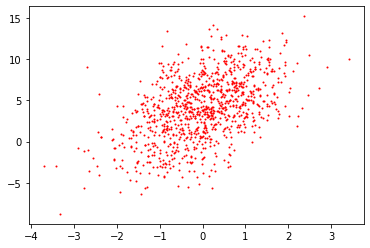

In [ ]:
plt.scatter(features[:,0].numpy(), labels.numpy(), 1, color='r');
plt.show()

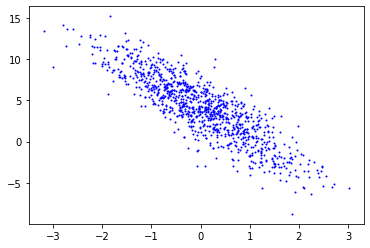

In [ ]:


plt.scatter(features[:, 1].numpy(), labels.numpy(), 1, color='b');
plt.show()




## Lecture de l'ensemble de données

Rappelons que les modèles de formation consistent en
faire plusieurs passages sur le jeu de données,
saisir un mini-lot d'exemples à la fois,
et les utiliser pour mettre à jour notre modèle.
Puisque ce processus est si fondamental
à la formation d'algorithmes de machine learning,
il vaut la peine de définir une fonction d'utilité
pour mélanger l'ensemble de données et y accéder par mini-lots.

Dans le code suivant, nous [**définissons la fonction `data_iter`**]
pour démontrer une implémentation possible de cette fonctionnalité.
La fonction (**prend une taille de lot, une matrice de fonctionnalités,
et un vecteur d'étiquettes, produisant des minilots de la taille `batch_size`.**)
Chaque mini-lot se compose d'un tuple de fonctionnalités et d'étiquettes.

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # Les exemples sont lus au hasard, sans ordre particulier
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

En général, notez que nous souhaitons utiliser des mini-lots de taille raisonnable
pour profiter du matériel GPU,
qui excelle dans la parallélisation des opérations.
Parce que chaque exemple peut être alimenté par nos modèles en parallèle
et le gradient de la fonction de perte pour chaque exemple peut également être pris en parallèle,
Les GPU nous permettent de traiter des centaines d'exemples en à peine plus de temps
qu'il n'en faudrait pour traiter un seul exemple.

Pour construire une certaine intuition, lisons et imprimons
le premier petit lot d'exemples de données.
La forme des caractéristiques de chaque mini-lot nous indique
à la fois la taille du mini-lot et le nombre d'entités en entrée.
De même, notre mini-lot d'étiquettes aura une forme donnée par `batch_size`.


In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print('X',X, '\n','y', y)
    break

X tf.Tensor(
[[-0.78584206  0.3075579 ]
 [-0.00983358  2.0147603 ]
 [ 0.38710403 -0.737084  ]
 [ 0.84614617  1.2053049 ]
 [ 1.015138    0.9259092 ]
 [-1.8908175   1.0491937 ]
 [ 0.01238819  2.3807662 ]
 [ 0.8190829   1.1271894 ]
 [ 0.21565393  0.11737844]
 [-0.4586126  -0.3474583 ]], shape=(10, 2), dtype=float32) 
 y tf.Tensor(
[[ 1.5687042]
 [-2.6589124]
 [ 7.4773054]
 [ 1.7697058]
 [ 3.0862198]
 [-3.1560016]
 [-3.8686547]
 [ 2.0006344]
 [ 4.2348514]
 [ 4.442527 ]], shape=(10, 1), dtype=float32)


Au fur et à mesure que nous exécutons l'itération, nous obtenons des mini-lots distincts
successivement jusqu'à ce que l'ensemble de données soit épuisé (essayez ceci).
Bien que l'itération implémentée ci-dessus soit bonne à des fins didactiques,
il est inefficace d'une manière qui pourrait nous attirer des ennuis sur de vrais problèmes.
Par exemple, cela nécessite que l'on charge toutes les données en mémoire
et que nous effectuons beaucoup d'accès mémoire aléatoire.
Les itérateurs intégrés mis en œuvre dans un cadre d'apprentissage en profondeur
sont considérablement plus efficaces et peuvent traiter
avec à la fois des données stockées dans des fichiers et des données alimentées via des flux de données.




## Initialisation des paramètres du modèle

[**Avant de pouvoir commencer à optimiser les paramètres de notre modèle**] par descente de gradient stochastique minibatch,
(**nous devons avoir certains paramètres en premier lieu.**)
Dans le code suivant, nous initialisons les poids par échantillonnage
nombres aléatoires d'une distribution normale de moyenne 0
et un écart type de 0,01, et en définissant le biais sur 0.

In [ ]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

After initializing our parameters,
our next task is to update them until
they fit our data sufficiently well.
Each update requires taking the gradient
of our loss function with respect to the parameters.
Given this gradient, we can update each parameter
in the direction that may reduce the loss.

Since nobody wants to compute gradients explicitly
(this is tedious and error prone),
we use automatic differentiation,
as introduced in :numref:`sec_autograd`, to compute the gradient.




## Définir le modèle

Ensuite, nous devons [**définir notre modèle,
reliant ses entrées et paramètres à ses sorties.**]
Rappelons que pour calculer la sortie du modèle linéaire,
on prend simplement le produit scalaire matrice-vecteur
des caractéristiques d'entrée $\mathbf{X}$ et les poids du modèle $\mathbf{w}$,
et ajoutez le décalage $b$ à chaque exemple.
Notez qu'en dessous de $\mathbf{Xw}$ se trouve un vecteur et $b$ est un scalaire.
Rappelez-vous le mécanisme de diffusion tel que décrit dans :numref:`subsec_broadcasting`.
Lorsque nous ajoutons un vecteur et un scalaire,
le scalaire est ajouté à chaque composante du vecteur.


In [ ]:
def linreg(X, w, b):  
    """The linear regression model."""
    return tf.matmul(X, w) + b

## Définition de la fonction de perte (erreur / Loss)

Puisque [**la mise à jour de notre modèle nécessite de prendre
le gradient de notre fonction de perte,**]
nous devrions (**définir la fonction de perte d'abord.**)
Ici, nous utiliserons la fonction de perte au carré
comme décrit dans :numref:`sec_linear_regression`.
Dans l'implémentation, nous devons transformer la vraie valeur `y`
dans la forme de la valeur prédite `y_hat`.
Le résultat renvoyé par la fonction suivante
aura également la même forme que `y_hat`.


In [ ]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape))**2 / 2

## Définition de l'algorithme d'optimisation

Comme nous l'avons vu dans :numref:`sec_linear_regression`,
la régression linéaire a une solution de forme fermée.
Cependant, ce n'est pas un livre sur la régression linéaire :
c'est un livre sur l'apprentissage en profondeur.
Étant donné qu'aucun des autres modèles présentés dans ce livre
peut être résolu analytiquement, nous profiterons de cette occasion pour présenter votre premier exemple de travail de
descente de gradient stochastique en mini-lot.


A chaque étape, en utilisant un mini-lot tiré au hasard dans notre jeu de données,
nous allons estimer le gradient de la perte par rapport à nos paramètres.
Ensuite, nous mettrons à jour nos paramètres
dans la direction qui peut réduire la perte.
Le code suivant applique la mise à jour de la descente de gradient stochastique par mini-lot,
étant donné un ensemble de paramètres, un taux d'apprentissage et une taille de lot.
La taille de l'étape de mise à jour est déterminée par le taux d'apprentissage "lr".
Parce que notre perte est calculée comme une somme sur le mini-lot d'exemples,
nous normalisons notre taille de pas par la taille du lot (`batch_size`),
de sorte que l'amplitude d'une taille de pas typique
ne dépend pas beaucoup de notre choix de la taille du lot.


In [ ]:
def sgd(params, grads, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr * grad / batch_size)

## Entraînement

Maintenant que nous avons toutes les pièces en place,
nous sommes prêts à [**mettre en œuvre la boucle d'entraînement principale.**]
Il est crucial que vous compreniez ce code
car vous verrez des boucles d'entraînement presque identiques
maintes et maintes fois tout au long de votre carrière dans l'apprentissage en profondeur.

À chaque itération, nous récupérerons un mini-lot d'exemples d'entraînement,
et les passer à travers notre modèle pour obtenir un ensemble de prédictions.
Après avoir calculé la perte, on initie le passage en arrière dans le réseau,
mémoriser les gradients par rapport à chaque paramètre.
Enfin, nous appellerons l'algorithme d'optimisation `sgd`
pour mettre à jour les paramètres du modèle.

En résumé, nous allons exécuter la boucle suivante :

* Initialiser les paramètres $(\mathbf{w}, b)$
* Répétez jusqu'à ce que vous ayez terminé
     * Calculer le gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
     * Mettre à jour les paramètres $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

A chaque *époque*,
nous allons parcourir l'ensemble de données
(en utilisant la fonction `data_iter`) une fois
en passant par chaque exemple dans l'ensemble de données d'apprentissage
(en supposant que le nombre d'exemples est divisible par la taille du lot).
Le nombre d'époques `num_epochs` et le taux d'apprentissage `lr` sont tous deux des hyperparamètres,
que nous fixons ici à 3 et 0,03, respectivement.
Malheureusement, la définition des hyperparamètres est délicate
et nécessite quelques ajustements par essais et erreurs.
Nous éliminons ces détails pour l'instant mais les révisons
plus tard dans
:numref:`chap_optimization`.


In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [ ]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # Minibatch loss dans `X` et `y`
        # calculer gradient de l par rapport à [`w`, `b`]
        dw, db = g.gradient(l, [w, b])
        # Updater les paramètres utilisant leurs gradients
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.046112
epoch 2, loss 0.000193
epoch 3, loss 0.000053


Dans ce cas, parce que nous avons synthétisé l'ensemble de données nous-mêmes,
nous savons précisément quels sont les vrais paramètres.
Ainsi, nous pouvons [**évaluer notre réussite en formation
en comparant les vrais paramètres
avec ceux que nous avons appris**] grâce à notre boucle de formation.
En effet, ils s'avèrent très proches les uns des autres.


In [ ]:
print(f'erreur dans l estimation  de w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'erreur dans l estimation  de b: {true_b - b}')

erreur dans l estimation  de w: [ 0.00074148 -0.00026917]
erreur dans l estimation  de b: [0.0009408]


Notez qu'il ne faut pas le prendre pour acquis
que nous sommes en mesure de récupérer parfaitement les paramètres.
Cependant, en apprentissage automatique, nous sommes généralement moins concernés
avec récupération des vrais paramètres sous-jacents,
et plus préoccupé par les paramètres qui conduisent à une prédiction très précise.
Heureusement, même sur des problèmes d'optimisation difficiles,
la descente de gradient stochastique peut souvent trouver des solutions remarquablement bonnes,
en partie du fait que, pour les réseaux profonds,
il existe de nombreuses configurations des paramètres
qui conduisent à une prédiction très précise.


## Sommaire

* Nous avons vu comment un réseau profond peut être implémenté et optimisé à partir de zéro, en utilisant uniquement des tenseurs et une différenciation automatique, sans avoir besoin de définir des couches ou des optimiseurs sophistiqués.


* Cette section ne fait qu'effleurer la surface de ce qui est possible. Dans les sections suivantes, nous décrirons des modèles supplémentaires basés sur les concepts que nous venons d'introduire et apprendrons à les mettre en œuvre de manière plus concise.




## Exercices


1. Pourquoi la fonction "reshape" est-elle nécessaire dans la fonction "squared_loss" ?

1. Expérimentez en utilisant différents taux d'apprentissage pour découvrir à quelle vitesse la valeur de la fonction de perte chute. Faites de même pour le nombre d'itérations.

1. Si le nombre d'exemples ne peut pas être divisé par la taille du lot, qu'arrive-t-il au comportement de la fonction `data_iter` ?

1. Re-tester l'exemple du Lab01 avec ce programme
